In [1]:
%load_ext autoreload
%autoreload 2

# Getting Started

## Import

In [174]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
import seaborn as sns
sns.set()

from rul_pm.dataset.lives_dataset import AbstractLivesDataset
from rul_pm.dataset.CMAPSS import (process_file_train, 
                                   process_file_test, engines, sensor_indices,
                                   operation_mode)
from rul_pm.iterators.iterators import LifeDatasetIterator
from rul_pm.iterators.utils import  true_values
from rul_pm.transformation.transformers import Transformer
from rul_pm.transformation.features.selection import (
    ByNameFeatureSelector,
    PandasVarianceThreshold,
    PandasNullProportionSelector)
from rul_pm.transformation.utils import PandasTransformerWrapper
from rul_pm.transformation.features.outliers import IQROutlierRemover, ZScoreOutlierRemover
from rul_pm.transformation.features.imputers import ForwardFillImputer, PandasMeanImputer
from rul_pm.transformation.features.scalers import PandasMinMaxScaler
from rul_pm.transformation.pipeline import LivesPipeline
from rul_pm.transformation.features.extraction import RollingStatisticsPandas
from rul_pm.transformation.transformerstep import Concatenate
from rul_pm.transformation.target import PicewiseRUL

from rul_pm.transformation.features.resamplers import ResamplerTransformer
from rul_pm.iterators.iterators import WindowedDatasetIterator, LifeDatasetIterator
from rul_pm.iterators.batcher import Batcher
from rul_pm.models.keras.models.simple import FCN
from rul_pm.models.keras.models.XiangQiangJianQiao import XiangQiangJianQiaoModel
from rul_pm.models.sklearn import SKLearnModel



from rul_pm.transformation.utils import PandasTransformerWrapper
from rul_pm.transformation.features.imputers import ForwardFillImputer, PandasRemoveInf, PerColumnImputer
from rul_pm.transformation.utils import IdentityTransformer
from rul_pm.graphics.duration import (durations_boxplot, 
                                      add_vertical_line,
                                      lives_duration_histogram, 
                                      lives_duration_histogram_from_durations)
from rul_pm.graphics.plots import (plot_true_and_predicted, 
                                   plot_life, 
                                   hold_out_barplot_errors_wrt_RUL_multiple_models,
                                   hold_out_boxplot_errors_wrt_RUL_multiple_models,
                                   plot_unexploited_lifetime,
                                   plot_unexpected_breaks)
from rul_pm.results.results import split_lives
from rul_pm.graphics.embedding import tsne
from rul_pm.dataset.analysis import null_proportion, null_proportion_per_life, variance_information

## Dataset

The Dataset comes in a space separated tabular file. The functions `process_file_train` and `process_file_test` receive the filename of the dataset file and return a `pd.DataFrame` with the pre-processed data. The `UnitNumber` column is a life identifier.

In order to define a dataset you should subclass `AbstractLivesDataset` and define three methods:

  * `__getitem__(self, i)`: This method should return the i-th life 
  * `nlives(self)`: In this method should return the total number of lives present in the dataset

In [17]:
class CMAPSSDataset(AbstractLivesDataset):
    def __init__(self, train=True, model=None):
        if model is not None:
            if model not in operation_mode:
                raise ValueError(
                    f'Invalid model: valid model are {list(operation_mode.keys())}')
        if train:
            processing_fun = process_file_train
        else:
            processing_fun = process_file_test
        self.lives = []
        for engine in engines:
            if model is not None and engine != model:
                continue
            for _, g in processing_fun(engine).groupby('UnitNumber'):
                g.drop(columns=['UnitNumber'], inplace=True)
                self.lives.append(g)
                
    @property
    def rul_column(self) -> str:
        return 'RUL'
    
    def __getitem__(self, i):
        return self.lives[i]

    @property
    def nlives(self):
        return len(self.lives)

In [18]:
train_dataset = CMAPSSDataset(train=True, model='FD001')
validation_dataset = CMAPSSDataset(train=False, model='FD001')

### Number of lives in the training set

In [19]:
len(train_dataset)

100

### Number of lives in the validation set

In [20]:
len(validation_dataset)

100

## Visualization

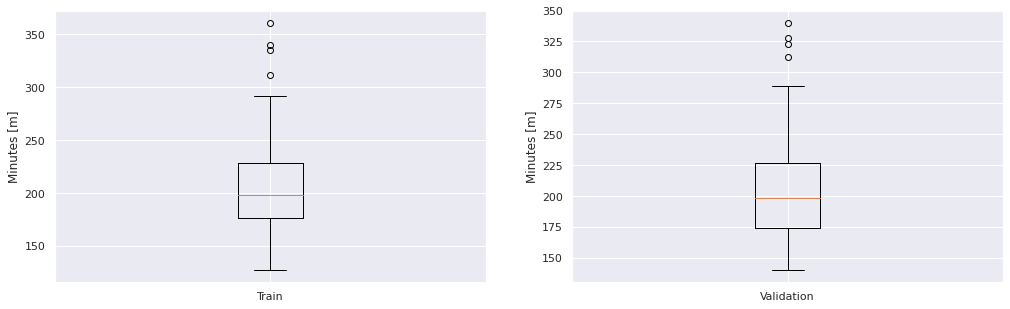

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
durations_boxplot(train_dataset, xlabel='Train', ylabel='Minutes [m]', ax=ax[0])
durations_boxplot(validation_dataset, xlabel='Validation', ylabel='Minutes [m]', ax=ax[1]);

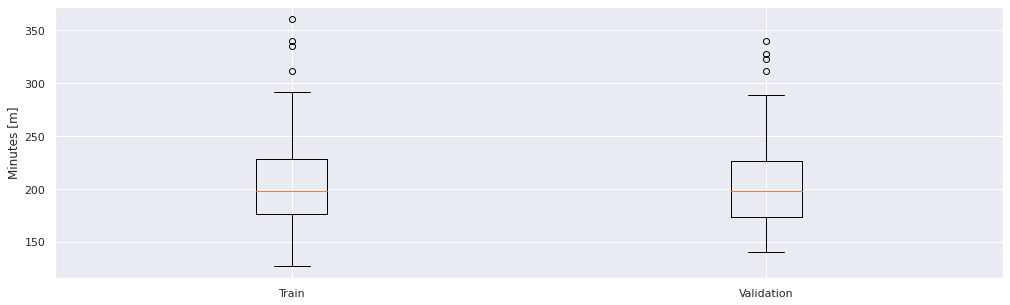

In [22]:
fig, ax = durations_boxplot([train_dataset, validation_dataset], 
                  xlabel=['Train', 'Validation'], 
                  ylabel='Minutes [m]',
                  figsize=(17, 5))

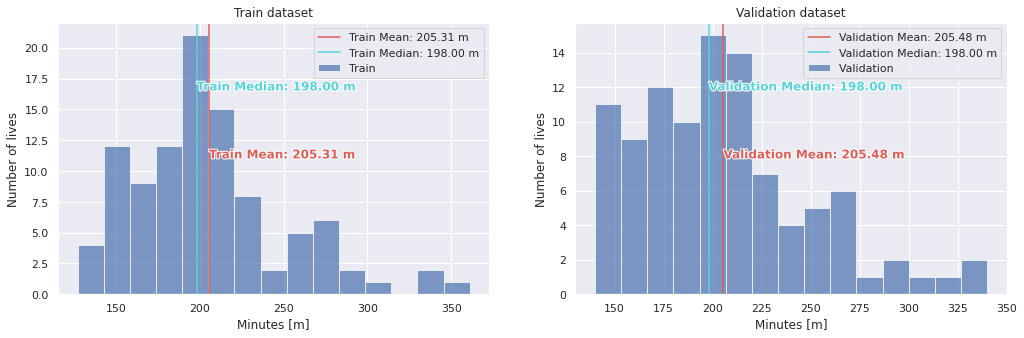

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
lives_duration_histogram(train_dataset, 
                         label='Train',
                         xlabel='Minutes [m]', 
                         alpha=0.7,
                         ax=ax[0])
ax[0].set_title('Train dataset')
lives_duration_histogram(validation_dataset, 
                         label='Validation',
                         xlabel='Minutes [m]', 
                         alpha=0.7,
                         ax=ax[1])
ax[1].set_title('Validation dataset');

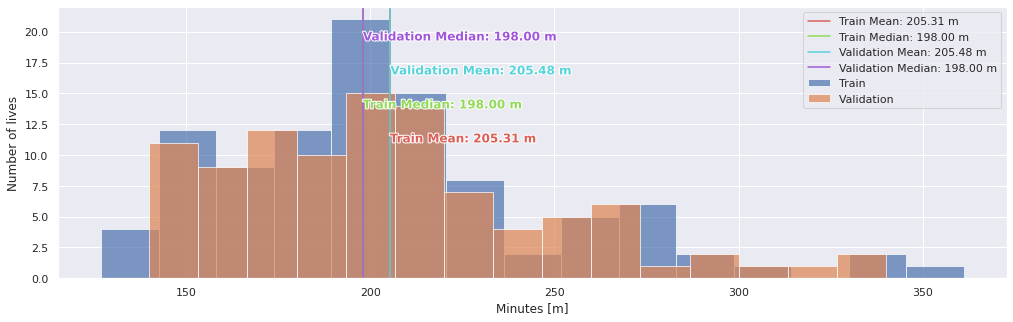

In [24]:
lives_duration_histogram([train_dataset,validation_dataset], 
                         label=['Train','Validation'],
                         xlabel='Minutes [m]', 
                         alpha=0.7,
                         figsize=(17, 5));

## Dataset analysis

### Missing values
Usually, the information of sensors is incomplete and this causes numerous missing values in the features. This library provides some useful functions to analyse the proportion of the missing values for each feature for each life. In some cases, if the feature values are missing in multiple lives, that feature can be discarded.

Luckily in the NASA dataset, we don't have any missing values:

In [25]:
df, null_per_life = null_proportion(train_dataset)
df

,Feature,Max Null Proportion,Mean Null Proportion
0,SensorMeasure9,0.0,0.0
14,OpSet2,0.0,0.0
25,SensorMeasure5,0.0,0.0
24,SensorMeasure2,0.0,0.0
23,SensorMeasure15,0.0,0.0
22,SensorMeasure8,0.0,0.0
21,SensorMeasure21,0.0,0.0
20,SensorMeasure18,0.0,0.0
19,SensorMeasure4,0.0,0.0
18,SensorMeasure10,0.0,0.0


In [26]:
null_proportion_per_life(train_dataset)

,Life,Number of features,Number of completely null features,N of features with 50% null,N of features with 25% null,Mean null propotion
0,0,27,0,0,0,0.0
63,63,27,0,0,0,0.0
73,73,27,0,0,0,0.0
72,72,27,0,0,0,0.0
71,71,27,0,0,0,0.0
...,...,...,...,...,...,...
30,30,27,0,0,0,0.0
29,29,27,0,0,0,0.0
28,28,27,0,0,0,0.0
27,27,27,0,0,0,0.0


### Variance
Another possibility is that sensors do not vary equally in a diverse set of lives. Another function obtains information about the variance of each feature per each life. If a feature variance is zero in many lives, maybe it is a good idea to remove it.

In the NASA dataset, we can see that some of the features have a zero variance in some of the lives.

In [27]:
df, var_per_life = variance_information(train_dataset)
df

,Feature,Min std Proportion,Mean std Proportion
1,SensorMeasure19,0.000000,0.000000e+00
20,SensorMeasure18,0.000000,0.000000e+00
18,SensorMeasure10,0.000000,2.203638e-16
8,SensorMeasure16,0.000000,5.321406e-18
9,SensorMeasure6,0.000000,9.590898e-04
10,OpMode,0.000000,0.000000e+00
11,SensorMeasure1,0.000000,2.280172e-15
17,OpSet3,0.000000,0.000000e+00
25,SensorMeasure5,0.000000,1.264424e-15
14,OpSet2,0.000269,2.897551e-04


## Transformers

There are two ways of defining a transformer. The first way is more similar to the scikit-learn Pipeline API, and the other one is similar to the tensorflow functional API.
Two pipelines have to be defined:
* How the data is going to be transformed
    * This transformer invovles selecting and transforming and generating features
* How the target is going to be transformed
    * This transformer involves selecting and transforming the target

The base class of the pipeline is the `LivesPipeline` class. This class is an extension of `sklearn.pipeline.Pipeline` and change the way the data is fitted. 
Each transformer class inherit from the `TransformerStep`. This class implements the method `partial_fit` which receives the data belonging to the whole life and update its internal state accordingly.

### Functional API

Following the literature, the future that addresses this dataset, only a subset of the feature are going to be used to fit our model.

In [29]:
features = [train_dataset[0].columns[i] for i in sensor_indices]
features

['SensorMeasure2',
 'SensorMeasure3',
 'SensorMeasure4',
 'SensorMeasure7',
 'SensorMeasure8',
 'SensorMeasure9',
 'SensorMeasure11',
 'SensorMeasure12',
 'SensorMeasure13',
 'SensorMeasure14',
 'SensorMeasure15',
 'SensorMeasure17',
 'SensorMeasure20',
 'SensorMeasure21']

The transformation of the input data will be simple, a feature scaling between -1 and 1 and imputing any missing value or non finite.

In [30]:
functional_pipe = ByNameFeatureSelector(features)
functional_pipe = PandasMinMaxScaler((-1,1), robust=False)(functional_pipe)
functional_pipe = PandasMeanImputer()(functional_pipe)

One common approach for handling PM problems is to downplay the early stages of the execution due to the fact that that is harder to detect indication of degradation at the beggining.

For this dataset, a piece-wise linear degradation model has been validated to be suitable and effective. In general, the engine unit works normally in the early age and degrades linearly afterwards. It is assumed to have a constant RUL label in the initial period.  [1]

[1] Li, X., Ding, Q., & Sun, J. Q. (2018). Remaining useful life estimation in prognostics using deep convolution neural networks. Reliability Engineering & System Safety, 172, 1-11.

In [31]:
target_pipe = ByNameFeatureSelector(['RUL'])
target_pipe = PicewiseRUL(125)(target_pipe)

In [32]:
functional_transformer = Transformer(
    transformerX=functional_pipe.build(),
    transformerY=target_pipe.build())


### Scikit-learn API

In [33]:
sklearn_pipe = Transformer(
    transformerX=LivesPipeline(
        steps=[
            ('selection', ByNameFeatureSelector(features)),
            ('scaler', PandasMinMaxScaler((-1,1), robust=True)),
            ('imputer', PandasMeanImputer())
        ]
    ),
    transformerY=LivesPipeline(
        steps=[
            ('select_RUL', ByNameFeatureSelector(['RUL']))
        ]
    )
    
)

sklearn_pipe.fit(train_dataset)


### Fitting the transformer

The transformer must be fitted on the dataset.

In [34]:
functional_transformer.fit(train_dataset)

### Transforming a life

In [35]:
X, y, m = functional_transformer.transform(train_dataset[0])

In [36]:
X.shape

(192, 14)

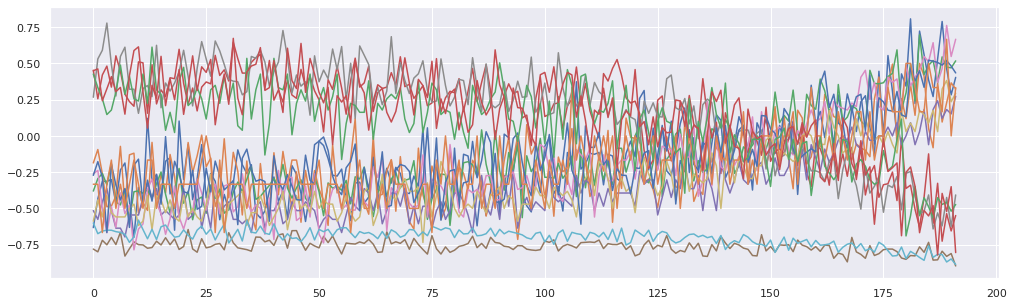

In [37]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(X);

### More complex transformers
More complex transformers can also be constructed. For example, we may want to use the raw features but also extract some statistics from a subset of features. In this case, we are going to obtain the kurtosis and the peak coefficient using a rolling window for 3 features. There are a lot of different feature extraction and transformation steps that can be applied. I encourage you to check the documentation to discover more.

The number of features we are going to obtain at the end will be the 14 coming from the raw features and 6=2*3 coming for the two statistics computed from the selected subset of size 3.

In [38]:
raw_pipe = ByNameFeatureSelector(features)
raw_pipe = ForwardFillImputer()(functional_pipe)
raw_pipe = PandasMinMaxScaler((-1,1), robust=False, name='raw_scaled')(functional_pipe)

transformed_pipe = ByNameFeatureSelector(features[0:3])
transformed_pipe = RollingStatisticsPandas(window=15, to_compute=['kurtosis', 'peak'])(transformed_pipe)
transformed_pipe = PandasMeanImputer()(transformed_pipe)
transformed_pipe = PandasMinMaxScaler((-1,1), robust=False, name='transformed_scaled')(transformed_pipe)


pipe = Concatenate()([raw_pipe, transformed_pipe])

target_pipe = ByNameFeatureSelector(['RUL'])

complex_transformer = Transformer(
    transformerX=pipe.build(),
    transformerY=target_pipe.build())

complex_transformer.fit(train_dataset)

In [39]:
X, y, m = complex_transformer.transform(train_dataset[0])

The number of features as expected is 20 features: 14 from the raw features and 6 from the extracted ones

In [40]:
X.shape

(192, 20)

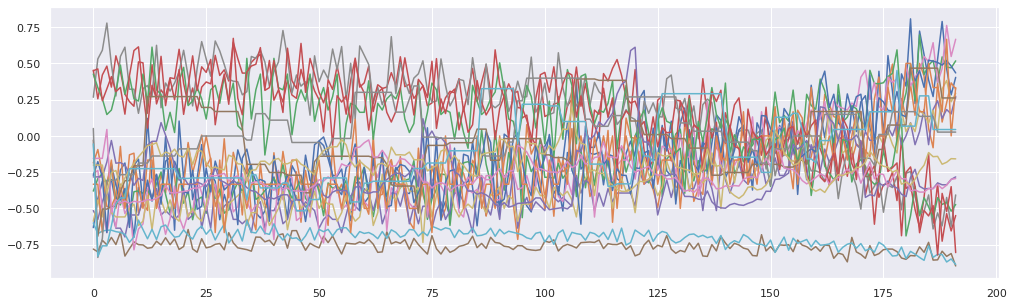

In [41]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(X);

The name of the obtained features are computed from the step names and the selected features

In [42]:
complex_transformer.columns()

array(['raw_scaled_0_SensorMeasure2', 'raw_scaled_0_SensorMeasure3',
       'raw_scaled_0_SensorMeasure4', 'raw_scaled_0_SensorMeasure7',
       'raw_scaled_0_SensorMeasure8', 'raw_scaled_0_SensorMeasure9',
       'raw_scaled_0_SensorMeasure11', 'raw_scaled_0_SensorMeasure12',
       'raw_scaled_0_SensorMeasure13', 'raw_scaled_0_SensorMeasure14',
       'raw_scaled_0_SensorMeasure15', 'raw_scaled_0_SensorMeasure17',
       'raw_scaled_0_SensorMeasure20', 'raw_scaled_0_SensorMeasure21',
       'transformed_scaled_1_SensorMeasure2_kurtosis',
       'transformed_scaled_1_SensorMeasure2_peak',
       'transformed_scaled_1_SensorMeasure3_kurtosis',
       'transformed_scaled_1_SensorMeasure3_peak',
       'transformed_scaled_1_SensorMeasure4_kurtosis',
       'transformed_scaled_1_SensorMeasure4_peak'], dtype=object)

## Iterators

### Lives iterator

The dataset can be iterated. Each element of the iteration is life in stored in `pd.DataFrame` which contains all the features

In [43]:
train_dataset[0].columns

Index(['Cycle', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure1',
       'SensorMeasure2', 'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure5',
       'SensorMeasure6', 'SensorMeasure7', 'SensorMeasure8', 'SensorMeasure9',
       'SensorMeasure10', 'SensorMeasure11', 'SensorMeasure12',
       'SensorMeasure13', 'SensorMeasure14', 'SensorMeasure15',
       'SensorMeasure16', 'SensorMeasure17', 'SensorMeasure18',
       'SensorMeasure19', 'SensorMeasure20', 'SensorMeasure21', 'RUL',
       'OpMode'],
      dtype='object')

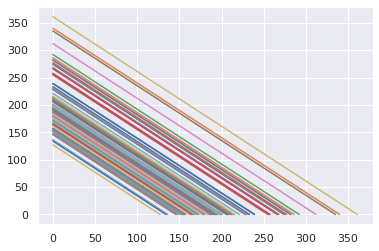

In [44]:
fig, ax = plt.subplots()
for life in train_dataset:
    ax.plot(life['RUL'].values)

### WindowedDatasetIterator
The windowed dataset iterator provides a way of iterating the transformed dataset trough an sliding window. The sample for the i-th element, provides the (window-1) elements of the window. It also provides capabilities to shuffle in diverse ways the how the samples are delivered by the iterator.

In [45]:
window = 7
iterator = WindowedDatasetIterator(
    train_dataset,
    window,
    functional_transformer,
    step=1,
    output_size=1,
    shuffle=False)

X, y, sw= next(iterator)

Since we are using the functional_transformer that only has 14 feature and a window size of 7 samples. The output of one element of the iterator wil be a matrix ox size (7 x14)

In [46]:
X.shape

(7, 14)

## Batcher

The batcher class make use of the `WindowedDatasetIterator` to generate batches of samples.

In [47]:
window = 25
batch_size = 66
step = 2
train_batcher = Batcher.new(train_dataset,  
                            window, 
                            batch_size, 
                            functional_transformer, 
                            step, 
                            shuffle=False)
X, y, sw = next(train_batcher)

As expected the shape of the input data of one batch is:
* 66 due to the batch size
* 25 because the lookback window size
* 14 for the selected features in the transformer

In [48]:
X.shape

(66, 25, 14)

In [49]:
y.shape

(66, 1, 1)

### How dos a sample looks like?

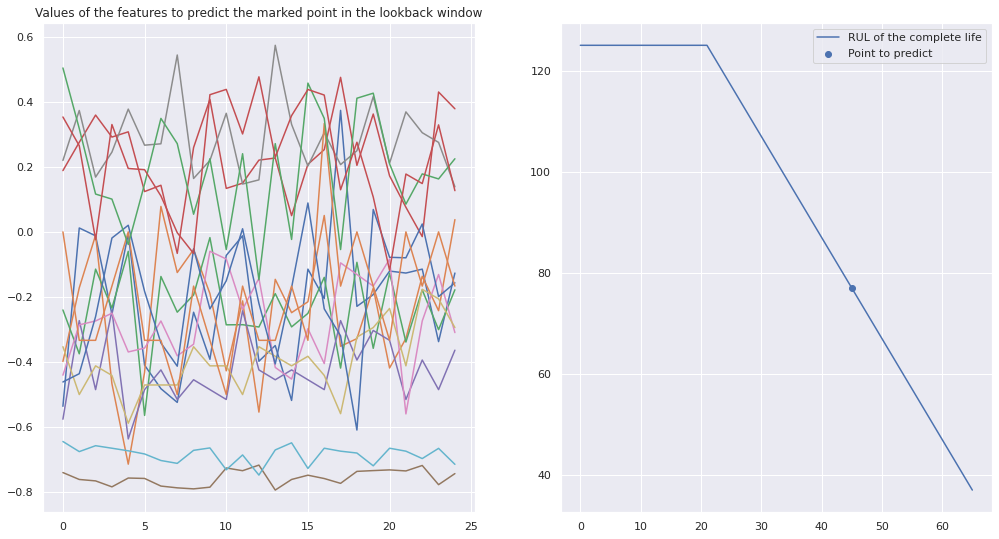

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(17, 9))
for f in range(X.shape[2]):
    ax[0].plot(X[45, :, f])
ax[0].set_title('Values of the features to predict the marked point in the lookback window')
ax[1].plot(np.squeeze(y), label='RUL of the complete life')
ax[1].scatter(x=45, y=y[45], label='Point to predict')
ax[1].legend()

## Model

### Keras models

Let's create a simple model in keras with some FC layers. 


First of all we need to create two batchers for feeding the model.

In [51]:
step = 1
batch_size = 16
window = 64
train_batcher = Batcher.new(train_dataset,  
                            window, 
                            batch_size, 
                            functional_transformer, 
                            step, 
                            shuffle='all',
                            cache_size=500)
val_batcher = Batcher.new(validation_dataset,  
                            window, 
                            batch_size, 
                            functional_transformer, 
                            step, 
                            shuffle=False,
                            cache_size=500,
                            restart_at_end=False)



A simple fully connected model is already implemented in the library. You can specify the number of layers and the hidden dimension

In [53]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=5)
model = FCN([512, 256],
            dropout=0.5,
            learning_rate=0.0001,
            loss='mse',
            batch_normalization=False,
            l2=None)

r = model.fit(train_batcher, val_batcher , epochs=25, callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 896)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               459264    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 590,849
Trainable params: 590,849
Non-trainable params: 0
__________________________________________________

### Saving the model

In [54]:
model.save('FC_example')

INFO:tensorflow:Assets written to: /home/luciano/fuentes/lru_gcd/doc/examples/FC_example/assets


#### Loading the model

In [55]:
model = FCN.load('FC_example')

#### Learning curves

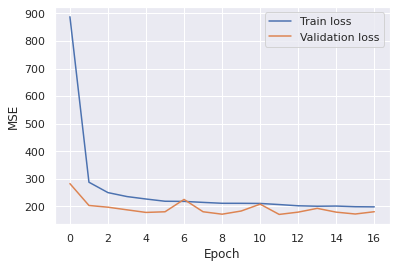

In [56]:
fig, ax = plt.subplots()
ax.plot(r['loss'], label='Train loss')
ax.plot(r['val_loss'], label='Validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.legend()

#### Prediction on the training set

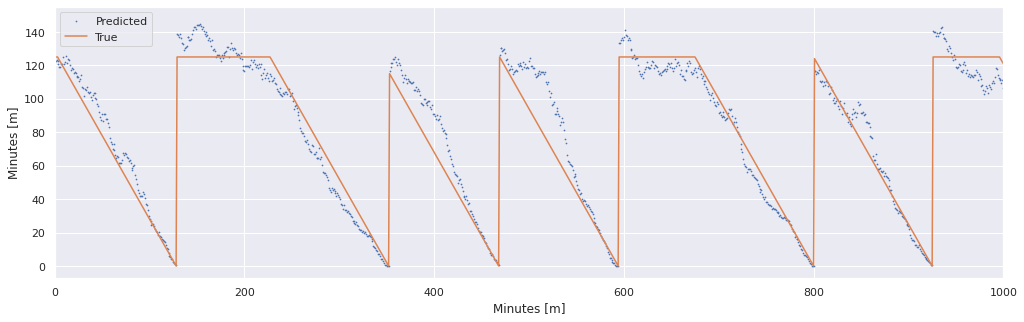

In [57]:
train_batcher = Batcher.new(train_dataset,  
                            window, 
                            batch_size, 
                            functional_transformer, 
                            1, 
                            cache_size=500,
                            shuffle=False,
                            restart_at_end=False)

y_pred = model.predict(train_batcher)
y_true = true_values(train_batcher.iterator)

temp_result = {
    'FCN':[
            {
                'true': y_true,
                'predicted': y_pred
        }
    ]
}

ax = plot_true_and_predicted(
    temp_result,
    units='Minutes [m]',
    figsize=(17, 5))

ax.set_xlim(0, 1000);

#### Prediction on the validation set

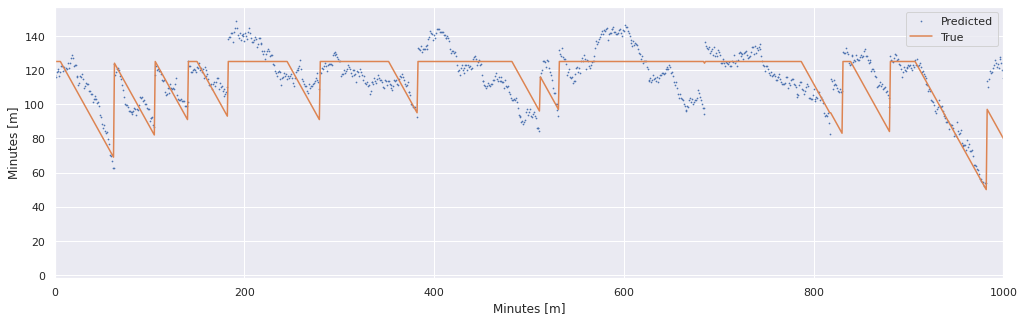

In [58]:

y_pred_fcn = model.predict(val_batcher)
y_true_fcn = true_values(val_batcher.iterator)
ax = plot_true_and_predicted(
    {
        'FCN': [
            {
                'true': y_true_fcn,
                'predicted': y_pred_fcn
            }
        ]
    },
    units='Minutes [m]',
    figsize=(17, 5))

ax.set_xlim(0, 1000);

Instead of having an array with all the predictions, another possibility to handling the predictions is using the `FittedLife class`. The function `split_lives` splits the whole set of predictions into a list of `FittedLife` objects.

In [104]:
lives = split_lives(y_true_fcn, y_pred_fcn, RUL_threshold=125)

/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1786: RuntimeWarning: divide by zero encountered in log
  (self.k_endog - nmissing - nsingular) * np.log(self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1786: RuntimeWarning: invalid value encountered in multiply
  (self.k_endog - nmissing - nsingular) * np.log(self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1787: RuntimeWarning: invalid value encountered in true_divide
  + scale_obs / self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1807: RuntimeWarning: divide by zero encountered in true_divide
  self.tmp2 = self.tmp2 / self.scale
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1807: RuntimeWarning: invalid value encountered in true_divi

In [105]:
lives[0:3]

We can plot one independent life and show also a RLS fitted from the predicted points

<AxesSubplot:xlabel='Unit Cycles', ylabel='Unit Cycles'>

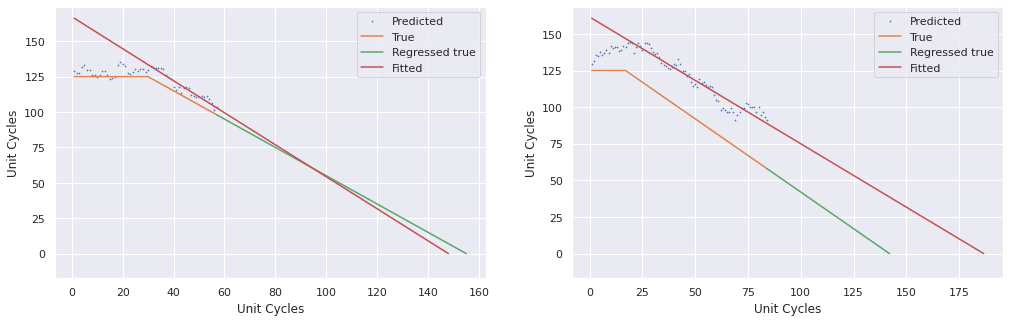

In [111]:
life1 = 42
life2 = 15
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
plot_life(lives[life1], units='Unit Cycles', add_fitted=True, ax=ax[0])
plot_life(lives[life2], units='Unit Cycles', add_fitted=True, ax=ax[1])

From each of the lives we cam compute diverse metrics:
* MAE
* RMSE
* Unexploited lifetime [1]
* Unexpected breaks [1]

[1] Machine Learning for Predictive Maintenance: A Multiple Classifiers Approach
    Susto, G. A., Schirru, A., Pampuri, S., McLoone, S., & Beghi, A. (2015). 

In [112]:

pd.DataFrame({
    'MAE': [lives[life1].mae(), lives[life2].mae()],
    'RMSE': [lives[life1].rmse(), lives[life2].rmse()],
    'Unexpected Break': [lives[life1].unexpected_break(), lives[life2].unexpected_break()],
    'Unexploited lifetime [m]': [lives[life1].unexploited_lifetime(), lives[life2].unexploited_lifetime()]
},
index=['Life 1', 'Life 2'])

,MAE,RMSE,Unexpected Break,Unexploited lifetime [m]
Life 1,5.225893,6.031584,False,7.031589
Life 2,23.642167,24.735506,True,0.000000


## A more complex model

We can use the model defined in the article "Remaining useful life estimation in prognostics using deep convolution neural networks" by Xiang Lia, Qian Ding and Jian-Qiao Sun already defined in the library.

In [113]:
from tensorflow.keras.callbacks import LearningRateScheduler

from rul_pm.models.keras.losses import root_mean_squared_error

step = 1
batch_size = 128
window = 30
train_batcher = Batcher.new(train_dataset,  
                            window, 
                            batch_size, 
                            functional_transformer, 
                            step, 
                            shuffle='all',
                            cache_size=500)
val_batcher = Batcher.new(validation_dataset,  
                            window, 
                            batch_size, 
                            functional_transformer, 
                            step, 
                            shuffle=False,
                            cache_size=500,
                            restart_at_end=False)

def scheduler(epoch, lr):
    """Learning rate as reported in the article"""
    if epoch < 17:
        return 0.001
    else:
        return 0.0001


model = XiangQiangJianQiaoModel(n_filters=10,
                                filter_size=10,
                                dropout=0.5,
                                loss=root_mean_squared_error, 
                                learning_rate=0.001)
r = model.fit(train_batcher, val_batcher , epochs=25, callbacks=[LearningRateScheduler(scheduler, verbose=True)])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 14)]          0         
_________________________________________________________________
lambda (Lambda)              (None, 30, 14, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 14, 10)        110       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 14, 10)        1010      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 14, 10)        1010      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 14, 10)        1010      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 14, 1)         31    

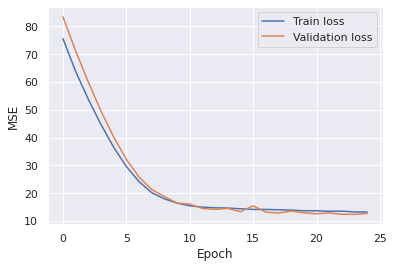

In [115]:
fig, ax = plt.subplots()
ax.plot(r['loss'], label='Train loss')
ax.plot(r['val_loss'], label='Validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.legend()

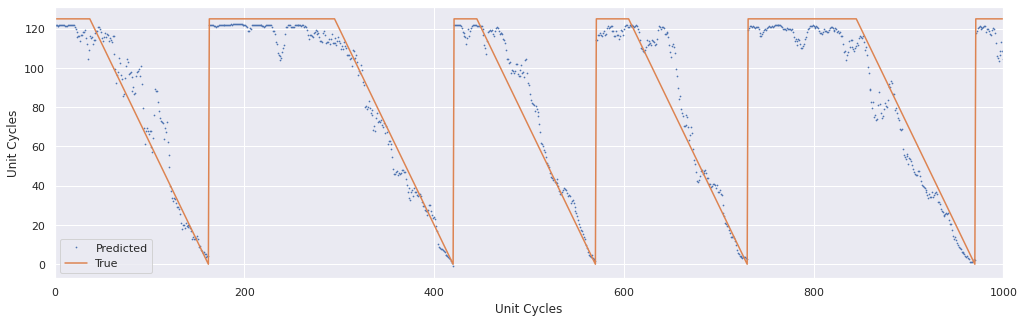

In [116]:
train_batcher = Batcher.new(train_dataset,  
                            window, 
                            batch_size, 
                            functional_transformer, 
                            step, 
                            shuffle=False,
                            cache_size=500)
y_pred = model.predict(train_batcher)
y_true = true_values(train_batcher.iterator)
ax = plot_true_and_predicted(
    {
        'XiangQiangJianQiaoModel': [
            {
                'true': y_true,
                'predicted': y_pred
            }
        ]
    },
    units='Unit Cycles',
    figsize=(17, 5))

ax.set_xlim(0, 1000);

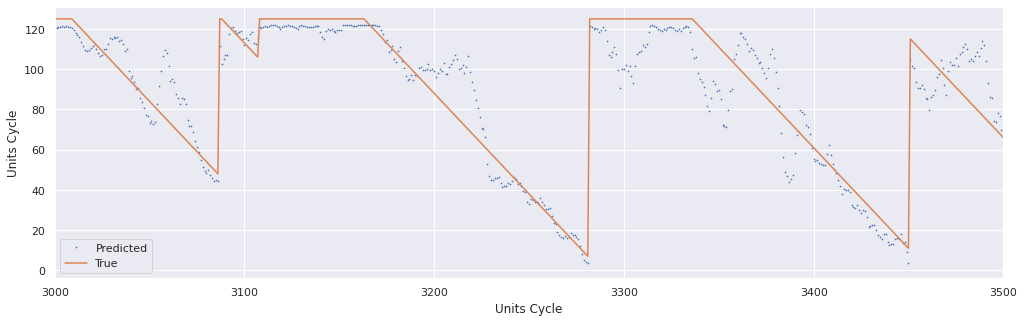

In [117]:

y_pred_XQJQ = model.predict(val_batcher)
y_true_XQJQ = true_values(val_batcher.iterator)
ax = plot_true_and_predicted(
    {
        'XiangQiangJianQiaoModel': [
            {
                'true': y_true_XQJQ,
                'predicted': y_pred_XQJQ
            }
        ]
    },
    units='Units Cycle',
    figsize=(17, 5))

ax.set_xlim(3000, 3500);

In [118]:
lives = split_lives(y_true, y_pred, RUL_threshold=125)

/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1786: RuntimeWarning: divide by zero encountered in log
  (self.k_endog - nmissing - nsingular) * np.log(self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1786: RuntimeWarning: invalid value encountered in multiply
  (self.k_endog - nmissing - nsingular) * np.log(self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1787: RuntimeWarning: invalid value encountered in true_divide
  + scale_obs / self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1807: RuntimeWarning: divide by zero encountered in true_divide
  self.tmp2 = self.tmp2 / self.scale
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1807: RuntimeWarning: invalid value encountered in true_divi

<AxesSubplot:xlabel='Units Cycle', ylabel='Units Cycle'>

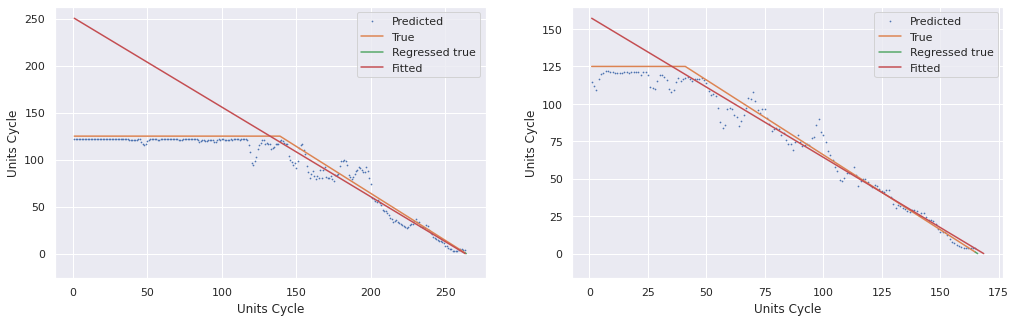

In [119]:
life1 = 82
life2 = 33
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
plot_life(lives[life1], units='Units Cycle', add_fitted=True, ax=ax[0])
plot_life(lives[life2], units='Units Cycle', add_fitted=True, ax=ax[1])

In [120]:

pd.DataFrame({
    'MAE': [lives[life1].mae(), lives[life2].mae()],
    'RMSE': [lives[life1].rmse(), lives[life2].rmse()],
    'Unexpected Break': [lives[life1].unexpected_break(), lives[life2].unexpected_break()],
    'Unexploited lifetime': [lives[life1].unexploited_lifetime(), lives[life2].unexploited_lifetime()]
},
index=['Life 1', 'Life 2'])

,MAE,RMSE,Unexpected Break,Unexploited lifetime
Life 1,6.946920,9.117927,False,0.751676
Life 2,5.363768,7.312658,True,0.000000


## A custom model
Also the library allows the creation of custom Keras and Pytorch models. 


In [51]:
from rul_pm.models.keras.keras import KerasTrainableModel
from tensorflow.keras import Model
from tensorflow.keras.layers import (Input, Conv1D, Flatten, Dense)


class CustomModel(KerasTrainableModel):
    def build_model(self, input_shape):
        x = Input(input_shape)
        input = x
        x = Conv1D(10, 15, activation='relu')(x)
        x = Flatten()(x)
        x = Dense(1, activation='relu')(x)
        return Model(inputs=[input], outputs=[x])
    

In [52]:


from rul_pm.models.keras.losses import root_mean_squared_error

step = 1
batch_size = 128
window = 30
train_batcher = Batcher.new(train_dataset,  
                            window, 
                            batch_size, 
                            functional_transformer, 
                            step, 
                            shuffle='all',
                            cache_size=500)
val_batcher = Batcher.new(validation_dataset,  
                            window, 
                            batch_size, 
                            functional_transformer, 
                            step, 
                            shuffle=False,
                            cache_size=500,
                            restart_at_end=False)




model = CustomModel(loss=root_mean_squared_error, 
                     learning_rate=0.001)
r = model.fit(train_batcher, val_batcher , epochs=25)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 14)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 16, 10)            2110      
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 161       
Total params: 2,271
Trainable params: 2,271
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
139/139 [==============================] - 3s 13ms/step - loss: 76.9651 - root_mean_squared_error: 67.6800 - val_loss: 25.3944 - val_root_mean_squared_error: 22.7123
Epoch 2/25
139/139 [==============================] - 1s 7ms/step - loss: 25.480

/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1786: RuntimeWarning: divide by zero encountered in log
  (self.k_endog - nmissing - nsingular) * np.log(self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1786: RuntimeWarning: invalid value encountered in multiply
  (self.k_endog - nmissing - nsingular) * np.log(self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1787: RuntimeWarning: invalid value encountered in true_divide
  + scale_obs / self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1807: RuntimeWarning: divide by zero encountered in true_divide
  self.tmp2 = self.tmp2 / self.scale
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1807: RuntimeWarning: invalid value encountered in true_divi

,MAE,RMSE,Unexpected Break,Unexploited lifetime
Life 1,6.946920,9.117927,False,0.751676
Life 2,5.363768,7.312658,True,0.000000


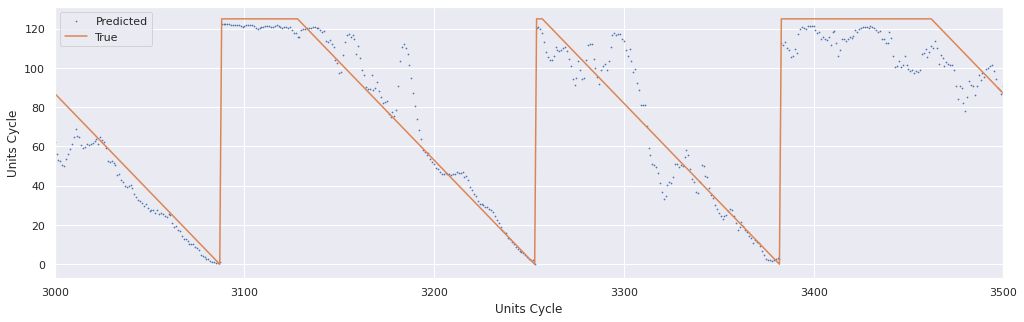

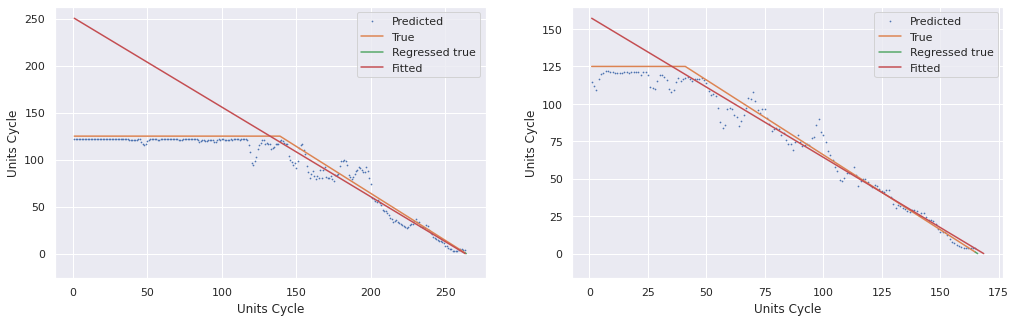

In [121]:

y_pred_custom = model.predict(val_batcher)
y_true_custom = true_values(val_batcher.iterator)
ax = plot_true_and_predicted(
    {
        'CustomModel': [
            {
                'true': y_true,
                'predicted': y_pred
            }
        ]
    },
    units='Units Cycle',
    figsize=(17, 5))

ax.set_xlim(3000, 3500);
lives = split_lives(y_true, y_pred, RUL_threshold=125)
life1 = 82
life2 = 33
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
plot_life(lives[life1], units='Units Cycle', add_fitted=True, ax=ax[0])
plot_life(lives[life2], units='Units Cycle', add_fitted=True, ax=ax[1])


pd.DataFrame({
    'MAE': [lives[life1].mae(), lives[life2].mae()],
    'RMSE': [lives[life1].rmse(), lives[life2].rmse()],
    'Unexpected Break': [lives[life1].unexpected_break(), lives[life2].unexpected_break()],
    'Unexploited lifetime': [lives[life1].unexploited_lifetime(), lives[life2].unexploited_lifetime()]
},
index=['Life 1', 'Life 2'])

### Scikit-learn and gradient boosting models
Following the same API we can create scikit-learn and XGBoost models for regressing our data.

##### Scikit-learn model
In the following example we are going to create a RandomForestRegressor to predict the RUL of the same dataset

In [122]:
from sklearn.ensemble import RandomForestRegressor



step = 1
window = 30
train_iterator = WindowedDatasetIterator(train_dataset,  
                            window, 
                            functional_transformer, 
                            step, 
                            shuffle='all',
                            cache_size=500)
val_iterator = WindowedDatasetIterator(validation_dataset,  
                            window, 
                            functional_transformer, 
                            step, 
                            shuffle=False,
                            cache_size=500)


model = SKLearnModel(RandomForestRegressor())
model.fit(train_iterator)

In [123]:
y_pred_rf = model.predict(val_iterator)
y_true_rf = true_values(val_iterator)

/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1786: RuntimeWarning: divide by zero encountered in log
  (self.k_endog - nmissing - nsingular) * np.log(self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1786: RuntimeWarning: invalid value encountered in multiply
  (self.k_endog - nmissing - nsingular) * np.log(self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1787: RuntimeWarning: invalid value encountered in true_divide
  + scale_obs / self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1807: RuntimeWarning: divide by zero encountered in true_divide
  self.tmp2 = self.tmp2 / self.scale
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1807: RuntimeWarning: invalid value encountered in true_divi

,MAE,RMSE,Unexpected Break,Unexploited lifetime
Life 1,6.946920,9.117927,False,0.751676
Life 2,5.363768,7.312658,True,0.000000


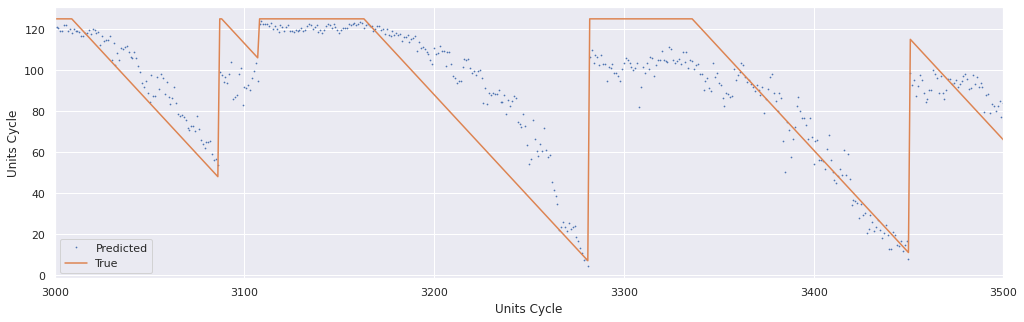

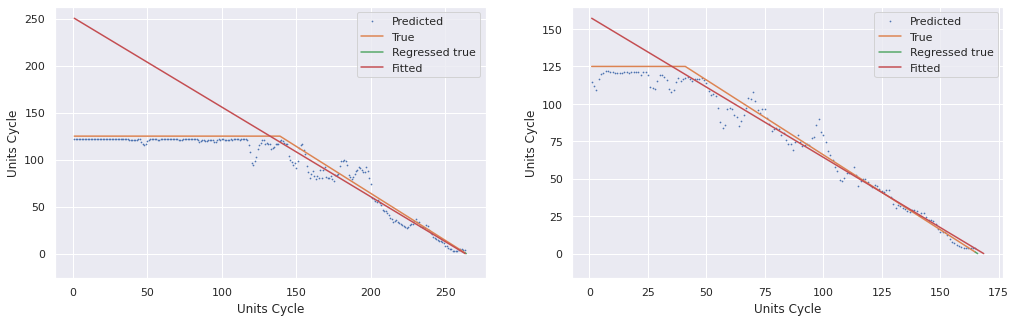

In [124]:
ax = plot_true_and_predicted(
    {
        'RandomForest': [
            {
                'true': y_true_rf,
                'predicted': y_pred_rf
            }
        ]
    },
    units='Units Cycle',
    figsize=(17, 5))

ax.set_xlim(3000, 3500);
lives = split_lives(y_true, y_pred, RUL_threshold=125)
life1 = 82
life2 = 33
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
plot_life(lives[life1], units='Units Cycle', add_fitted=True, ax=ax[0])
plot_life(lives[life2], units='Units Cycle', add_fitted=True, ax=ax[1])


pd.DataFrame({
    'MAE': [lives[life1].mae(), lives[life2].mae()],
    'RMSE': [lives[life1].rmse(), lives[life2].rmse()],
    'Unexpected Break': [lives[life1].unexpected_break(), lives[life2].unexpected_break()],
    'Unexploited lifetime': [lives[life1].unexploited_lifetime(), lives[life2].unexploited_lifetime()]
},
index=['Life 1', 'Life 2'])

##### Gradient boosting model

In [125]:
from rul_pm.models.gradientboosting import XGBoostModel
model = XGBoostModel()
model.fit(train_iterator)

In [126]:
y_pred_gb = model.predict(val_iterator)
y_true_gb = true_values(val_iterator)

/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1786: RuntimeWarning: divide by zero encountered in log
  (self.k_endog - nmissing - nsingular) * np.log(self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1786: RuntimeWarning: invalid value encountered in multiply
  (self.k_endog - nmissing - nsingular) * np.log(self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1787: RuntimeWarning: invalid value encountered in true_divide
  + scale_obs / self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1807: RuntimeWarning: divide by zero encountered in true_divide
  self.tmp2 = self.tmp2 / self.scale
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1807: RuntimeWarning: invalid value encountered in true_divi

,MAE,RMSE,Unexpected Break,Unexploited lifetime
Life 1,6.946920,9.117927,False,0.751676
Life 2,5.363768,7.312658,True,0.000000


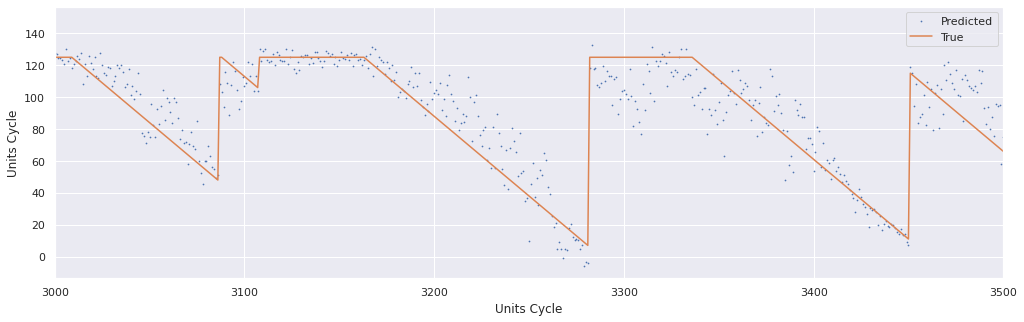

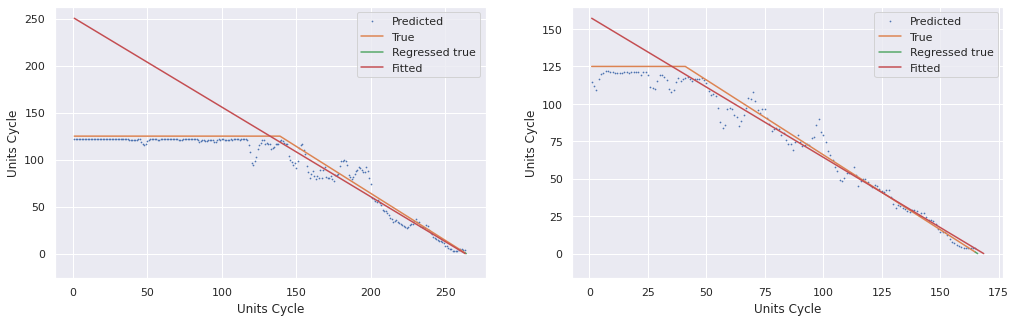

In [127]:
ax = plot_true_and_predicted(
    {
        'Gradient Boosting': [
            {
                'true': y_true_gb,
                'predicted': y_pred_gb
            }
        ]
    },
    units='Units Cycle',
    figsize=(17, 5))

ax.set_xlim(3000, 3500);
lives = split_lives(y_true, y_pred, RUL_threshold=125)
life1 = 82
life2 = 33
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
plot_life(lives[life1], units='Units Cycle', add_fitted=True, ax=ax[0])
plot_life(lives[life2], units='Units Cycle', add_fitted=True, ax=ax[1])


pd.DataFrame({
    'MAE': [lives[life1].mae(), lives[life2].mae()],
    'RMSE': [lives[life1].rmse(), lives[life2].rmse()],
    'Unexpected Break': [lives[life1].unexpected_break(), lives[life2].unexpected_break()],
    'Unexploited lifetime': [lives[life1].unexploited_lifetime(), lives[life2].unexploited_lifetime()]
},
index=['Life 1', 'Life 2'])

## Model comparison and evaluation

One of the most important issues regarding PM is the ability to compare and evaluate different methods.

The main data structure used in the results module is a dictionary in which each of the keys is the model name, and the elements are a list of dictionaries. Each of the dictionaries contains two keys: true, predicted. 
Each element of the model array is interpreted as a Fold in CV settings. If the array contains only one element it can be considered that the evaluation has been made on a hold-out set.

For this poropouse there are function for visualizing the results on a hold-out set:

- `hold_out_barplot_errors_wrt_RUL_multiple_models`
- `hold_out_boxplot_errors_wrt_RUL_multiple_models`

And for visualizing the reults on a cross validated predictions:

- `cv_barplot_errors_wrt_RUL_multiple_models`
- `cv_boxplot_errors_wrt_RUL_multiple_models`




This in an example of the dictionary structure

```python
    {
        'Model Name': [
            {
                'true': [true_0, true_1,...., true_n],
                'predicted': [pred_0, pred_1,...., pred_n]
            },
            {
                'true': [true_0, true_1,...., true_m],
                'predicted': [pred_0, pred_1,...., pred_m]
            },
            ...
        'Model Name 2': [
             {
                'true': [true_0, true_1,...., true_n],
                'predicted': [pred_0, pred_1,...., pred_n]
            },
            {
                'true': [true_0, true_1,...., true_m],
                'predicted': [pred_0, pred_1,...., pred_m]
            },
            ...
        ]
    }
```


The first step is to construct our data structure. Since we evaluated in a hold-out set, each list of each model will contain only one element.

In [159]:
results = {
    'FCN': [
        {
            'true': y_true_fcn,
            'predicted': y_pred_fcn
        }
    ],
    'XiangQiangJianQiao': [
        {
            'true': y_true_XQJQ,
            'predicted': y_pred_XQJQ
        }
    ],
    'Custom': [
        {
            'true': y_true_custom,
            'predicted': y_pred_custom
        }
    ],
    'Gradient Boosting': [
        {
            'true': y_true_gb,
            'predicted': y_pred_gb,
        }
    ],
    'Random forest': [
        {
            'true': y_true_rf,
            'predicted': y_pred_rf
        }
    ]
}

### Bar Plot

(<Figure size 1224x360 with 1 Axes>,
 <AxesSubplot:xlabel='RUL', ylabel='$y - \\hat{y}$ Cycle Units'>)

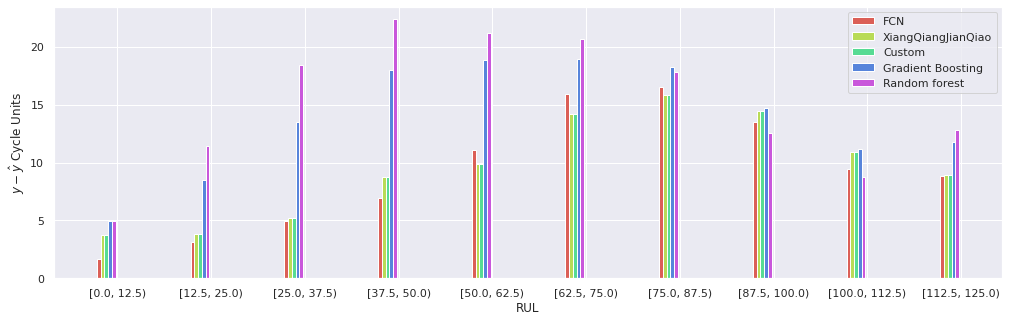

In [160]:
hold_out_barplot_errors_wrt_RUL_multiple_models(results, 10, figsize=(17, 5), y_axis_label=' Cycle Units')

### Box Plot

(<Figure size 1224x360 with 2 Axes>,
 <AxesSubplot:xlabel='RUL', ylabel='$y - \\hat{y}$ Cycle Units'>)

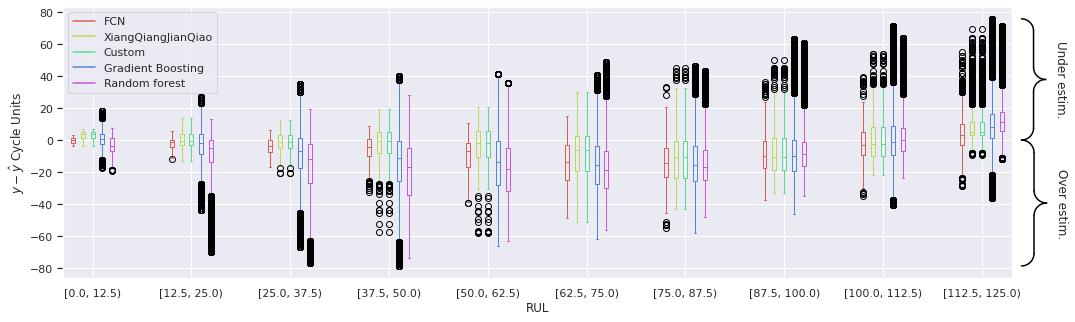

In [161]:
hold_out_boxplot_errors_wrt_RUL_multiple_models(results, 10, figsize=(17, 5), y_axis_label=' Cycle Units')

### 
Additionaly to the regression error, it is possible to compute some metrics more easily interpretable. In this context, two metrics were defined in [1], namely:

- Frequency of Unexpected Breaks (ρUB) - percentage of failures not prevented;
- Amount of Unexploited Lifetime (ρUL) - average number of time that could have been run before failure if the preventative maintenance suggested by the maintenance management mod-ule had not been performed.

After fitting straight line on the predicted points, a comparison between the point where the predicted fitted line arrives at the predicted end of life with respect to the true predicted end  of that particular life is made. 

In that case, three scenarios can happen:
- The predicted fitted line arrives at the zero remaining useful life before the true one. In that case, the predictions were pessimistic and the tool could have been used more time.
- The predicted fitted line arrives at zero after the true remaining useful life. In that case, we incur the risk of the tool breaking.  
- The predicted line coincides with the true line. In that case, we don’t have unexploited time, and the risk of breakage can be considered 0.


Since usually the breakages are considered more harmful, a possible approach to preventing unexpected failures is to consider a more conservative maintenance approach, providing maintenance tasks recommendations sometime before the end of life predicted. In that way, a conservative window can be defined in which the recommendation of making maintenance task should be performed at time T-predicted - conservative window size.

It is possible to visualize how it grows the unexploited lifetime grows as the conservative window size grows and how the unexpected breaks decrease as the conservative window size grows.




[1] Machine Learning for Predictive Maintenance: A Multiple Classifiers Approach
    Susto, G. A., Schirru, A., Pampuri, S., McLoone, S., & Beghi, A. (2015). 

/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1786: RuntimeWarning: divide by zero encountered in log
  (self.k_endog - nmissing - nsingular) * np.log(self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1786: RuntimeWarning: invalid value encountered in multiply
  (self.k_endog - nmissing - nsingular) * np.log(self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1787: RuntimeWarning: invalid value encountered in true_divide
  + scale_obs / self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1807: RuntimeWarning: divide by zero encountered in true_divide
  self.tmp2 = self.tmp2 / self.scale
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1807: RuntimeWarning: invalid value encountered in true_divi

/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1786: RuntimeWarning: divide by zero encountered in log
  (self.k_endog - nmissing - nsingular) * np.log(self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1786: RuntimeWarning: invalid value encountered in multiply
  (self.k_endog - nmissing - nsingular) * np.log(self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1787: RuntimeWarning: invalid value encountered in true_divide
  + scale_obs / self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1807: RuntimeWarning: divide by zero encountered in true_divide
  self.tmp2 = self.tmp2 / self.scale
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1807: RuntimeWarning: invalid value encountered in true_divi

/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1786: RuntimeWarning: divide by zero encountered in log
  (self.k_endog - nmissing - nsingular) * np.log(self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1786: RuntimeWarning: invalid value encountered in multiply
  (self.k_endog - nmissing - nsingular) * np.log(self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1787: RuntimeWarning: invalid value encountered in true_divide
  + scale_obs / self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1807: RuntimeWarning: divide by zero encountered in true_divide
  self.tmp2 = self.tmp2 / self.scale
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1807: RuntimeWarning: invalid value encountered in true_divi

/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1786: RuntimeWarning: divide by zero encountered in log
  (self.k_endog - nmissing - nsingular) * np.log(self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1786: RuntimeWarning: invalid value encountered in multiply
  (self.k_endog - nmissing - nsingular) * np.log(self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1787: RuntimeWarning: invalid value encountered in true_divide
  + scale_obs / self.scale)
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1807: RuntimeWarning: divide by zero encountered in true_divide
  self.tmp2 = self.tmp2 / self.scale
/home/luciano/venvs/general38/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1807: RuntimeWarning: invalid value encountered in true_divi

<AxesSubplot:title={'center':'Unexpected breaks'}, xlabel='Fault window size [Cycle units]', ylabel='Risk of breakage'>

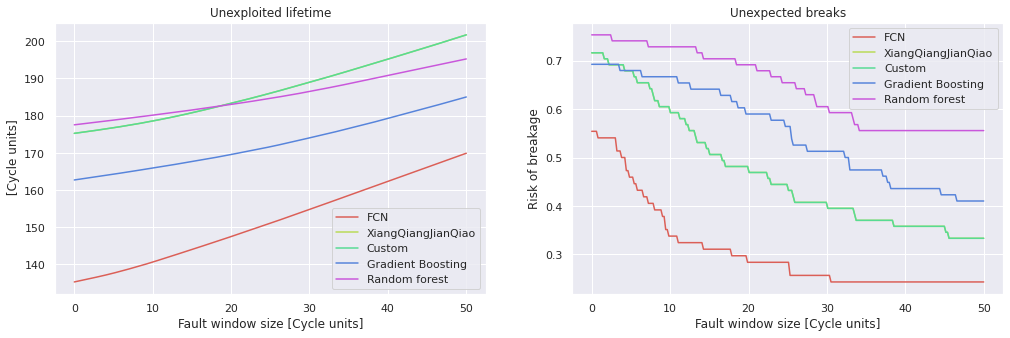

In [180]:
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
plot_unexploited_lifetime(results, max_window=50, n=250, ax=ax[0], units=' [Cycle units]')
plot_unexpected_breaks(results, max_window=50, n=250, ax=ax[1], units=' [Cycle units]')